## 라이브러리 임포트
- 실습에 필요한 라이브러리 임포트.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기(학습데이터, 테스트  데이터)
- 데이터 분석 단계에서 생성한 넝구 선수 포지션 예측하기의 학습 데이터 및 테스트를 로드.

In [2]:
train = pd.read_csv('data/csv/basketball_trian.csv')
test = pd.read_csv('data/csv/basketball_test.csv')

## SVM 최적의 파라미터 찾기
- 1. C(cost, 비용) : 결정경계의 마진을 결정하는 파라미터.
- 2. gamma : 커널의 데이터 포인트의 표준편차를 결정하는 파라미터. 

### - sklearn에서 제공하는 gridsearch를  사용하면 손쉽게 최적의 c,gamma를 구할 수 있다.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [4]:
def svc_param_selection(X, y, nfolds):     # 매개변수에 다항일때는 대문자로 사용한다.
    svm_parameters = [
        {
            'kernel' : ['rbf'],    # rbf적용법
            'gamma' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],  # gamma 적용법
            'C':[0.01, 0.1, 1, 10, 100, 1000]
        }
    ]
    
    clf = GridSearchCV(SVC(), svm_parameters, cv=nfolds)
    clf.fit(X, y)
    print(clf.best_params_)
    
    return clf
    


In [5]:
X_train = train[['3P', 'BLK']]
y_train = train[['Pos']]

# 최적의 파라미터를 sklearn의 GridSearchCV()를 통해 구한다.
clf = svc_param_selection(X_train, y_train.values.ravel(), 10)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


## 시각화
- 최적의 파라미터일때의 결정경계선과, 다른 파라미터들일 때의 결정경계선을 비교.

In [6]:
# 시각화를 하기 위해, 최적의 C와 다른 C를 후보로 저장한다.

C_candidaties = []
C_candidaties.append(clf.best_params_['C'] * 0.01)
C_candidaties.append(clf.best_params_['C'])
C_candidaties.append(clf.best_params_['C'] * 100)

# 시각화를 하기 위해, 최적의 gamma와 다른 gamma를 후보로 저장한다.

gamma_candidaties = []
gamma_candidaties.append(clf.best_params_['gamma'] * 0.01)
gamma_candidaties.append(clf.best_params_['gamma'])
gamma_candidaties.append(clf.best_params_['gamma'] * 100)

In [7]:
X = train[['3P','BLK']]
Y = train['Pos'].tolist()

# 포지션에 해당하는 문자열 'SG'와 'C'를 벡터화한다.
position = []
for gt in Y:
    if gt== 'C':
        position.append(0)
    else:
        position.append(1)

In [8]:
# 각각의 파리미터에 해당하는 SVM 모델을 만들어 classifiers에 저장한다.
classifiers = []
for C in C_candidaties:
    for gamma in gamma_candidaties:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, Y)
        classifiers.append((C, gamma, clf))

C:\ProgramData\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
C:\ProgramData\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names


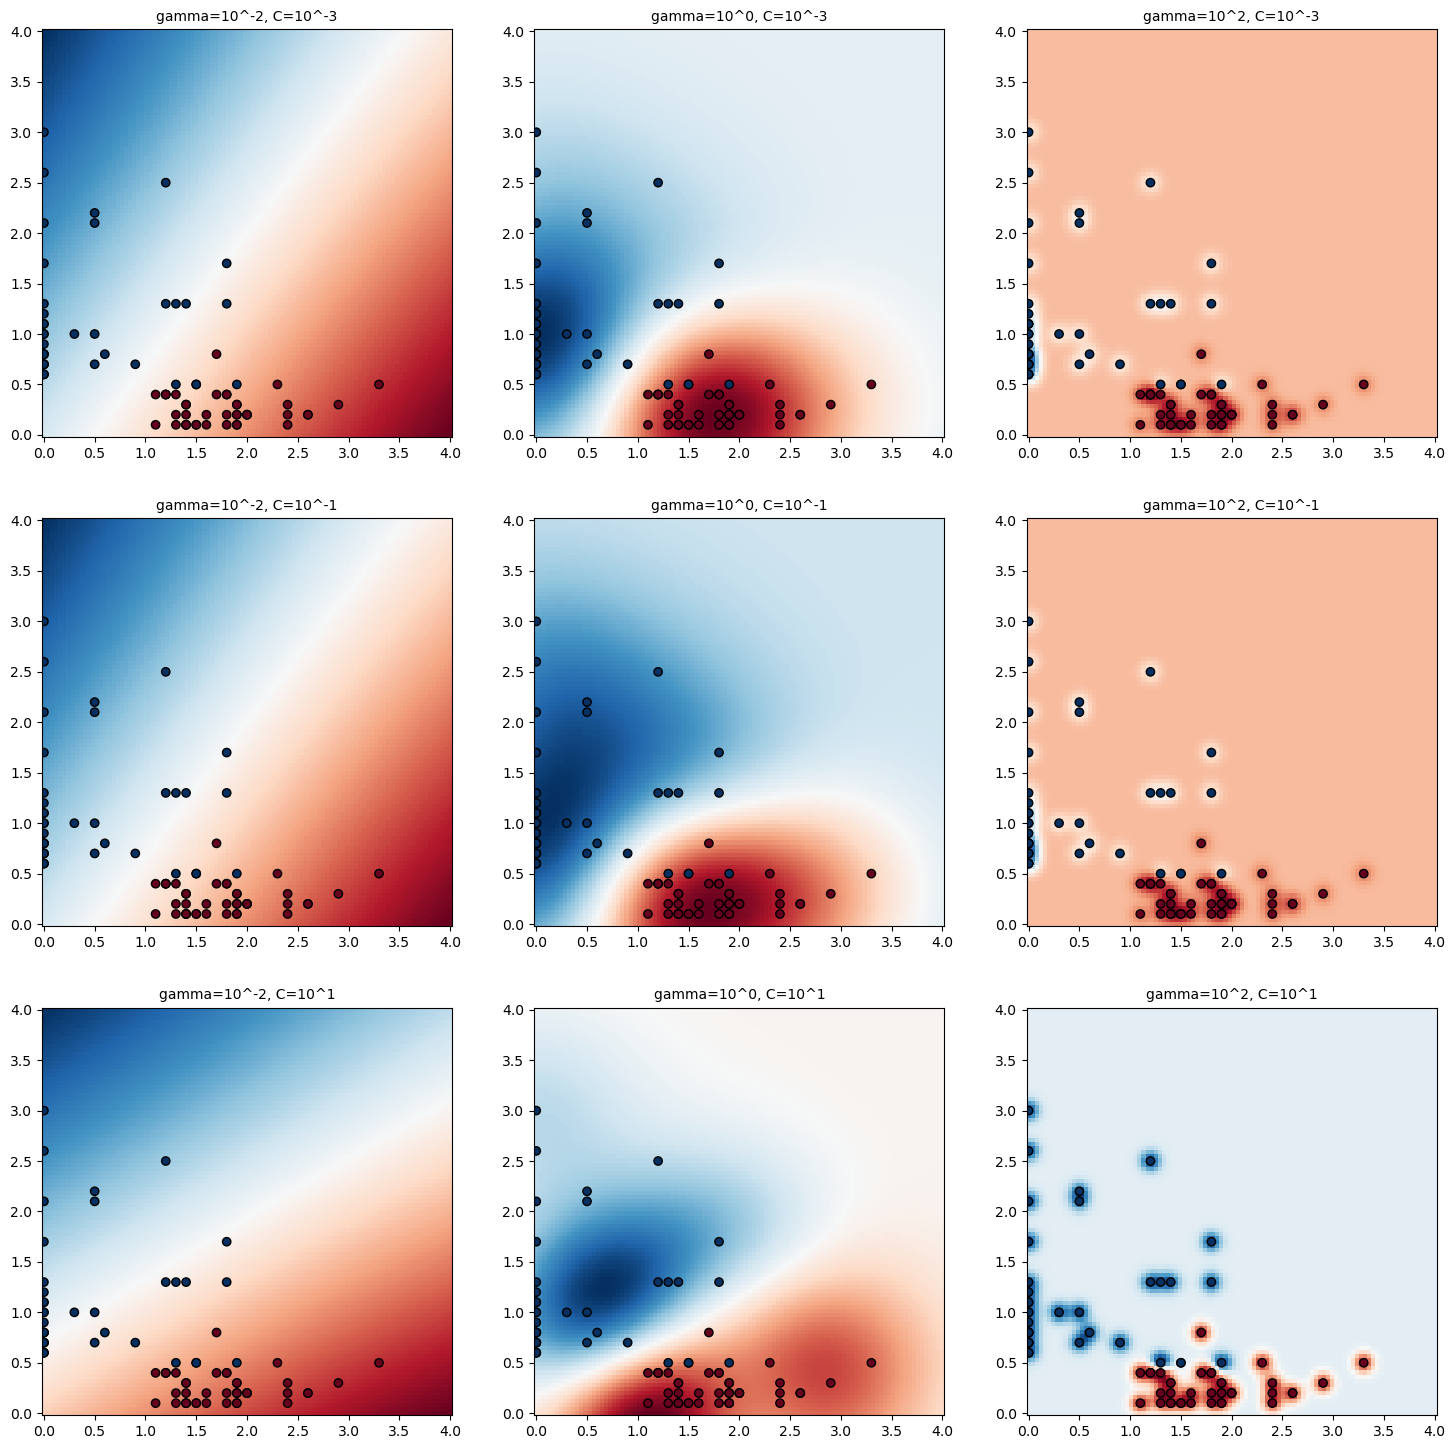

In [13]:
# 18, 18 사이즈의 차트를 구성
plt.figure(figsize=(18, 18))
xx, yy = np.meshgrid(np.linspace(0, 4 , 100), np.linspace(0, 4 , 100))  # linspace(0,4,100) 시작 끝 100으로 균등한 사이즈로 만들어준다

# 각각의 모델들 에 대한 결정 경계 함수를 적용하여 함께 시각화
for (k, (C, gamma, clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(),yy.ravel()])  # decision_function 결정 경계에 의한 가장 가까운 데이터를 찾아준다.
    Z = Z.reshape(xx.shape)
    
    # 최적의 모델을 포함한 다른 파라미터로 학습된 모델들을 함께 시각화.
    plt.subplot(len(C_candidaties), len(gamma_candidaties), k + 1)
    plt.title('gamma=10^%d, C=10^%d' %(np.log10(gamma), np.log10(C)), size='medium')
    plt.pcolormesh(xx, yy, -Z, cmap = plt.cm.RdBu)
    plt.scatter(X['3P'], X['BLK'], c=position, cmap=plt.cm.RdBu_r, edgecolors='k')

In [10]:
# cf)
# test_x, test_y = np.meshgrid([1, 2, 3], [1, 2, 3])
# print(test_x)
# print(test_y)


## 테스트
- sklearn의 gridsearch로 얻어진 최적의 파라미터로 학습된 clf를 이용하요 테스트 진행

In [23]:
# 테스트에 사용될 특징을 지정
X_test = test[['3P','BLK']]

# 특징으로 예측할 값(농구선수 포지션)을 지정
Y_test = test[['Pos']]

# 최적의 파라미터로 완성된 SVM에 테스트 데이터를 주입하여, 실제값과 예측값을 얻는다.

y_true, y_pred = Y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred))
#precision:정밀도    recall: 재현률  f1-score   support
print('accuracy : ' + str(accuracy_score(y_true, y_pred)))



              precision    recall  f1-score   support

           C       0.86      1.00      0.92        12
          SG       1.00      0.75      0.86         8

    accuracy                           0.90        20
   macro avg       0.93      0.88      0.89        20
weighted avg       0.91      0.90      0.90        20

accuracy : 0.9


In [25]:
comparision = pd.DataFrame({'prediction:':y_pred, 'tarket':Y_test.values.ravel()})
comparision

,prediction:,tarket
0,C,C
1,C,C
2,C,C
3,C,C
4,C,C
5,SG,SG
6,SG,SG
7,SG,SG
8,C,C
9,SG,SG
